In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import pandas as pd
import os
import emcee
import corner
from getdist import plots, gaussian_mixtures, MCSamples
import time

# Data

In [4]:
#binned Pantheon SNe Ia data
full_data = pd.read_csv('Pantheon_SNeIa_dataset/lcparam_DS17f.txt',sep=' ')

redshift = full_data['zcmb']
appmag = full_data['mb']
appmag_unc = full_data['dmb']

#absolute magnitude for Type 1a SNe
absmag = -19.25

#distance modulus = m - M
distmod = appmag - absmag
distmod.shape
distmod_unc = appmag_unc

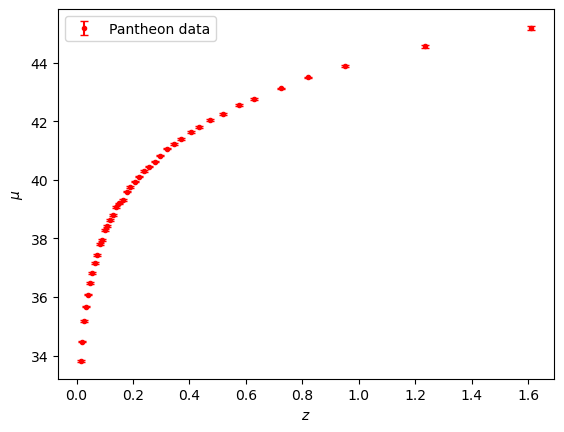

In [5]:
plt.figure()
plt.errorbar(redshift, distmod, yerr=distmod_unc, capsize=3, fmt='r.', label='Pantheon data')
plt.xlabel('$z$')
plt.ylabel('$\mu$')
plt.legend()
plt.show()

# Numerical Solution

In [6]:
#Calculate distance modulus
def calc_mu(Om, Orad, Ol, h):
    H0   = h*2.13312e-42
    H0_1 = 1/H0

    # z-axis
    nz   = 200
    zmin = 0
    zmax = 1.7
    z    = np.linspace(zmin, zmax, nz)

    # Integrand of luminosity distance    
    di   = np.zeros(nz)
    for i in range(0,nz):
        az = 1/(z[i]+1)
        az2 = az**2
        di[i] = az/(H0*np.sqrt(Om/az+Orad/az2+Ol*az2))
     
    # mu
    mu   = np.zeros(nz)
    dz2 = (z[1]-z[0])/2
    for i in range(1,nz):
        mu[i] = mu[i-1]+dz2*(di[i]+di[i-1])
    for i in range(1,nz):
        mu[i] = 5*np.log10((1+z[i])*mu[i]/1.5637382e38)+25
    return z[1:nz], mu[1:nz]

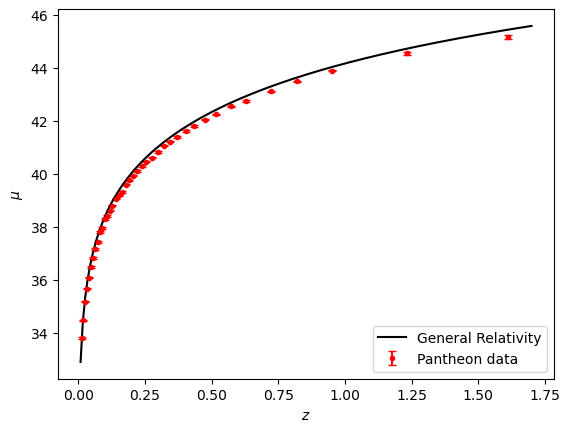

In [7]:
# model: GR =general relativity, EC = Einstein Cartan, CG = CCGG
# Planck:
#   Om,    Orad,    Ol,     Ok  ,  h 
# 0.315, 5.44e-5, 0.685,  0.000, 0.674)

z_GR, mu_GR = calc_mu(0.315, 5.44e-5, 0.685, 0.674)

# plot
plt.figure()
plt.errorbar(redshift, distmod, yerr=distmod_unc, capsize=3, fmt='r.', label='Pantheon data')
plt.plot(z_GR, mu_GR, 'k', label='General Relativity')
plt.xlabel('$z$')
plt.ylabel('$\mu$')
plt.legend(loc='lower right')
plt.show()

# Interpolation

In [8]:
from scipy import interpolate

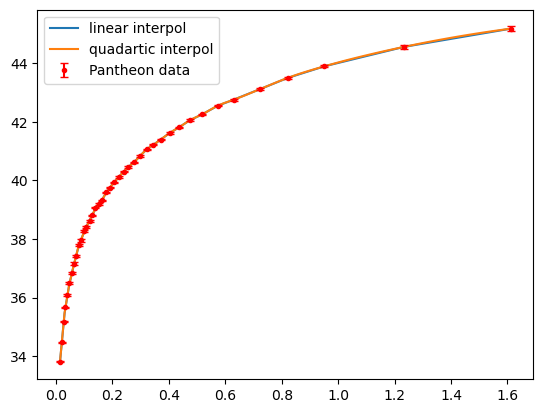

In [9]:
#Test
f1 = interpolate.interp1d(redshift, distmod, kind = 'linear')
f2 = interpolate.interp1d(redshift, distmod, kind = 'quadratic')

x_int = np.linspace(0.0140,1.6123,100)
plt.figure()
plt.plot(x_int, f1(x_int),label='linear interpol')
plt.plot(x_int, f2(x_int),label='quadartic interpol')
plt.errorbar(redshift, distmod, yerr=distmod_unc, capsize=3, fmt='r.', label='Pantheon data')
plt.legend()
plt.show()

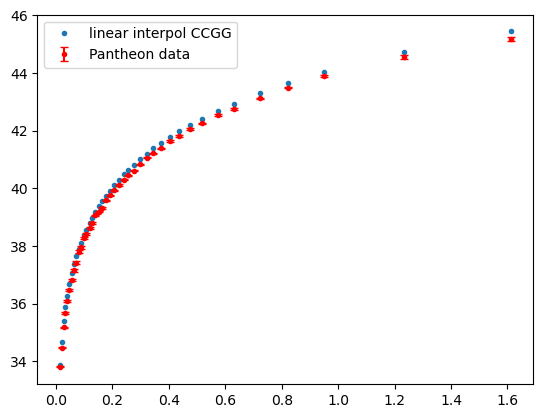

In [10]:
#Interpolate the 200 numerically computed values
f = interpolate.interp1d(z_GR, mu_GR, kind = 'linear')
#print(f(redshift))

#plot values of the interpolation function vs real data
mu_theo = f(redshift)
plt.figure()
plt.plot(redshift, mu_theo,'.',label='linear interpol CCGG')
plt.errorbar(redshift, distmod, yerr=distmod_unc, capsize=3, fmt='r.', label='Pantheon data')
plt.legend()
plt.show()

# MCMC

In [11]:
# Define the log_likelihood function
def log_likelihood(params):
    Om, Ol = params
    z_GR, mu_GR = calc_mu(Om, 5.44e-5, Ol, 0.674)
    f = interpolate.interp1d(z_GR, mu_GR, kind = 'linear')
    return -0.5*np.sum(((distmod.values - f(redshift))/distmod_unc.values)**2 + np.log(2*np.pi*distmod_unc**2))

In [12]:
log_likelihood([0.3,0.7])

-822.7725188388331

In [13]:
# Uniform log_prior
def log_prior(params):
    Om, Ol = params
    if  0.2 <= Om <= 0.4 and 0.6 <= Ol <= 0.8:
        return -np.log(0.2*0.2)
    return -np.inf

In [14]:
log_prior([0.3,0.7])

3.2188758248682006

In [15]:
#Product, resp. sum in logarithm form of likelihood and prior
def log_sum(params):
    # Compute the log-prior
    lp = log_prior(params)
    if lp == -np.inf:
        # If the prior is zero (i.e. log is -infinity), return negative infinity
        return -np.inf
    
    # Compute the log-likelihood
    ll = log_likelihood(params)
    
    # Compute the log-posterior as the sum of the log-prior and log-likelihood
    return lp + ll

In [16]:
log_sum([0.3,0.7])

-819.5536430139649

In [17]:
# Set the number of dimensions (i.e. the number of parameters)
ndim = 2

# Set the number of walkers
nwalkers = 7

# Define the range of values for each parameter
theta_min = [0.2, 0.6]
theta_max = [0.4, 0.8]

# Generate random starting positions for the walkers within the defined range
p0 = np.zeros((nwalkers, ndim))
for i in range(ndim):
    p0[:, i] = np.random.uniform(theta_min[i], theta_max[i], size=nwalkers)

# Initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_sum, args=())

In [18]:
# Run the sampler for a specified number of iterations
n_iterations = 10000
sampler.run_mcmc(p0, n_iterations, progress=True)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:17<00:00, 31.45it/s]


State([[0.37723658 0.79327342]
 [0.38715221 0.77132975]
 [0.3613993  0.79921106]
 [0.37178565 0.79556905]
 [0.37111983 0.7913211 ]
 [0.36975465 0.79433952]
 [0.37321388 0.78925243]], log_prob=[78.70130037 76.88327923 77.01338527 79.4400107  78.55664065 78.97952349
 78.56750159], blobs=None, random_state=('MT19937', array([1768214920, 3150332249, 2149661019, 3247475166, 2413720036,
       3452665495, 4161809749, 1768585896, 2083115460, 2340406029,
       3180639046,  875394334, 4243713103, 3780327648,  176694532,
       2107457521, 1275497642,  850769431, 1169486362, 1975677955,
       1879454151, 1209334927, 1627823809, 2009371755, 2945274812,
       1359925334, 3423306931,  499656386,  690423152, 2608312006,
       3882201026, 2683964292, 4132482279, 3957754874, 1268667727,
       2844396776, 3165772993, 1038780267, 1457552761, 2945160375,
        163058913, 1413585234, 2464675697, 3954428227,  900912774,
        330840001, 2343934534, 3110649517, 2197868974, 3366446304,
       362201

In [19]:
# Get the chain of samples produced by the sampler
#samples = sampler.chain[:, :, :].reshape((-1, ndim))
samples = sampler.chain[:, :, :]
print(sampler.chain[:,:,:].shape)

# Discard the first few samples as burn-in
burnin = 200
final_samples = samples[:,burnin:, :]
print(final_samples.shape)

(7, 10000, 2)
(7, 9800, 2)


(68600, 2)


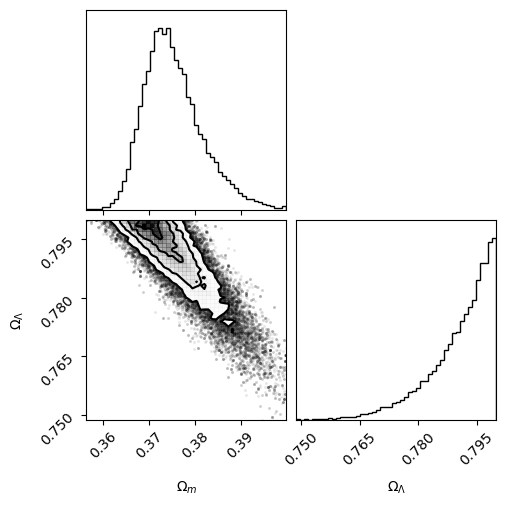

In [20]:
# Flatten the chain of samples
flat_samples = final_samples.reshape(-1, ndim)
print(flat_samples.shape)

# Plot the corner plot using the flattened samples
figure = corner.corner(flat_samples,bins=50, labels=['$\Omega_m$','$\Omega_\Lambda$'])

# Show the plot
plt.show()

Removed no burn in


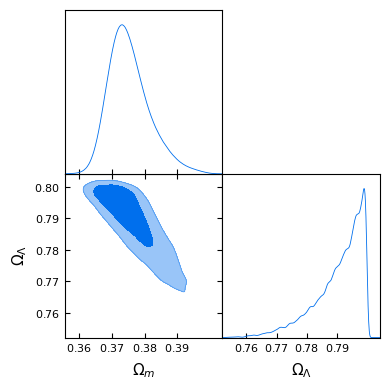

In [21]:
names = ['Omega_m','Omega_L']
labels =  ['\Omega_m','\Omega_\Lambda']
samples_new = MCSamples(samples=np.array(flat_samples),names=names,labels=labels)
g = plots.get_subplot_plotter()
g.triangle_plot(samples_new, filled=True)

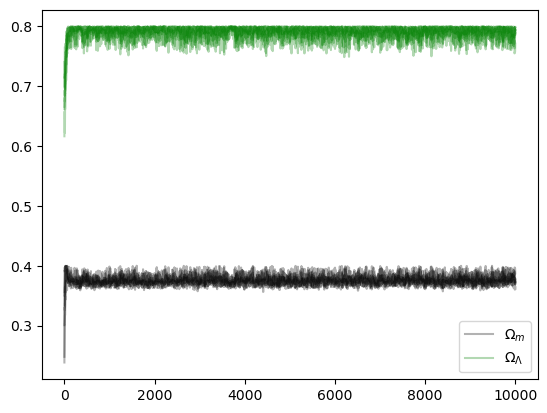

In [22]:
plt.figure()
plt.plot(samples[0,:,0].T, '-', color='k', alpha=0.3,label='$\Omega_m$')
plt.plot(samples[1:,:,0].T, '-', color='k', alpha=0.3)
plt.plot(samples[0,:,1].T, '-', color='g', alpha=0.3,label='$\Omega_\Lambda$')
plt.plot(samples[1:,:,1].T, '-', color='g', alpha=0.3)
plt.legend()
plt.show()

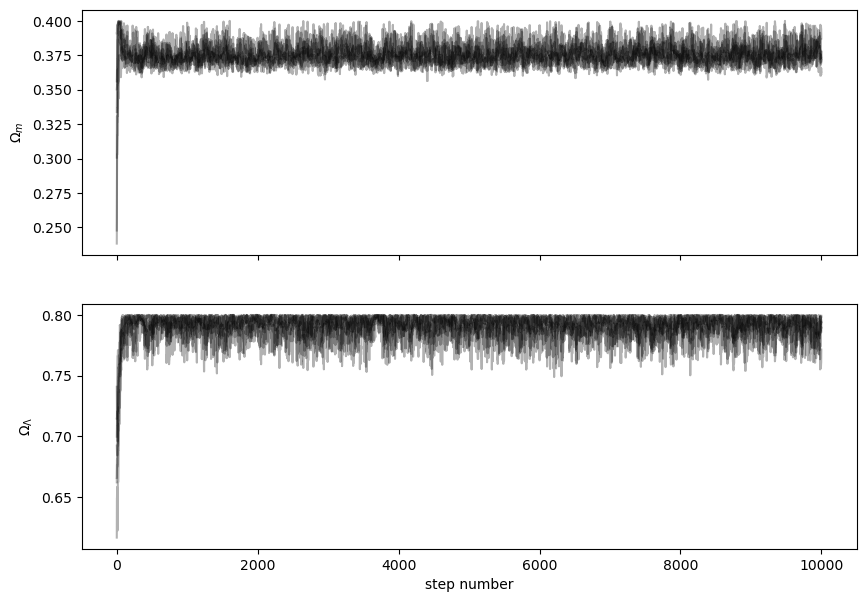

In [23]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$\Omega_m$", "$\Omega_\Lambda$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(sampler.chain[:,:,i].T, "k-", alpha=0.3)
    #ax.set_xlim(0, 10000)
    ax.set_ylabel(labels[i])

axes[-1].set_xlabel("step number");

In [24]:
sampler.chain[:,:,0].T.shape

(10000, 7)

In [25]:
#mean and std dev of Om_m
m1 = np.mean(flat_samples[:,0])
std1 = np.std(flat_samples[:,0])
print('Mean of Om_m = ',m1)
print('Std dev of Om_m = ',std1)

#mean and std dev of Om_l
m3 = np.mean(flat_samples[:,1])
std3 = np.std(flat_samples[:,1])
print('Mean of Om_l = ',m3)
print('Std dev of Om_l = ',std3)


Mean of Om_m =  0.37535828308566227
Std dev of Om_m =  0.0063791955191614515
Mean of Om_l =  0.790573493120484
Std dev of Om_l =  0.008067086662429236


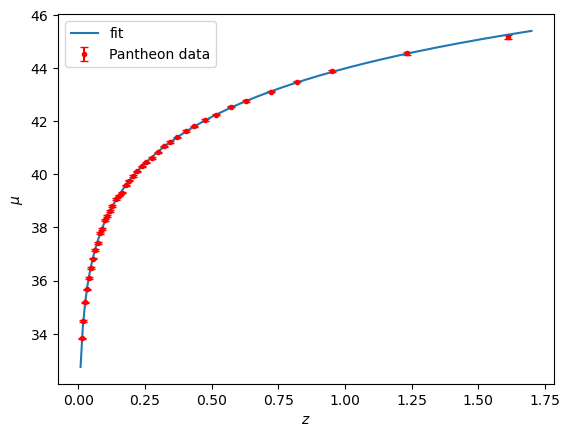

In [26]:
#Best fit
z_fit, mu_fit = calc_mu(m1, 5.44e-5, m3, 0.674)

plt.figure()
plt.errorbar(redshift, distmod, yerr=distmod_unc, capsize=3, fmt='r.', label='Pantheon data')
plt.plot(z_fit,mu_fit,label='fit')
plt.plot
plt.xlabel('$z$')
plt.ylabel('$\mu$')
plt.legend()
plt.show()